# Оптимизация выполнения кода, векторизация, Numba

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Оптимизация выполнения кода, векторизация, Numba"
* IPython Cookbook, Second Edition (2018), глава 4
* https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html
* https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

## Задачи для совместного разбора

In [1]:
# !pip install line_profiler

In [2]:
import numpy as np
from numba import njit
import numba

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [3]:
A = np.random.randint(0, 1000, size=(1000000))

In [4]:
def f1(A):
    acc = 0
    cnt = 0
    for i in range(len(A)):
        bi = A[i] + 100
        acc += bi
        cnt += 1
    return acc / cnt

In [5]:
%%time
f1(A)

Wall time: 377 ms


599.222235

In [6]:
%time f1(A)

Wall time: 336 ms


599.222235

In [7]:
%%timeit
f1(A)

352 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
def f2(A):
    acc = 0
    n = len(A)
    for i in range(n):
        acc += A[i]
    return acc / n + 100

In [9]:
%time f2(A)

Wall time: 173 ms


599.222235

In [10]:
%%time 
A.mean()+100

Wall time: 3.48 ms


599.222235

In [11]:
@njit
def f3(A):
    acc = 0
    n = len(A)
    for i in range(n):
        acc += A[i]
    return acc / n + 100

In [12]:
%%time 
f3(A)

Wall time: 591 ms


599.222235

2. Напишите функцию, которая возвращает сумму всех чисел от 0 до x-1. Примените функцию к каждому элементу массива.

In [13]:
def g(x):
    return sum(range(x))

In [14]:
%%time
np.array([g(x) for x in A])

Wall time: 7.87 s


array([303810, 299151, 301476, ...,  72771, 143916, 478731])

In [15]:
g_v = np.vectorize(g)

In [16]:
%%time
g_v(A)

Wall time: 7.59 s


array([303810, 299151, 301476, ...,  72771, 143916, 478731])

In [17]:
A.dtype

dtype('int32')

In [18]:
# !pip3 install --user --upgrade numba==0.56.3

In [19]:
g_v2 = numba.vectorize(["int32(int32)"])(g)

In [20]:
numba.__version__

'0.56.3'

In [21]:
%%time
g_v2(A)

Wall time: 80.3 ms


array([303810, 299151, 301476, ...,  72771, 143916, 478731])

3. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [22]:
%load_ext line_profiler

In [23]:
import pandas as pd
import string

N = 2_000_000
df = pd.DataFrame(np.random.randn(N, 4), columns=[f"col{i}" for i in range(4)])
df["key"] = np.random.choice(list(string.ascii_letters.lower()), N, replace=True)
df.head(2)

,col0,col1,col2,col3,key
0,0.180537,-1.407737,-0.841830,1.257013,j
1,-0.461220,-0.893670,-0.658863,0.870896,w


In [24]:
def h1(df):
    mask = []
    for _, row in df.iterrows():
        mask.append(row['key'] in {'a', 'b', 'c', 'd', 'e'})
    return df[mask]

In [25]:
# %%time
# h1(df.head(50000))

In [26]:
%lprun -f h1 h1(df.head(50000))

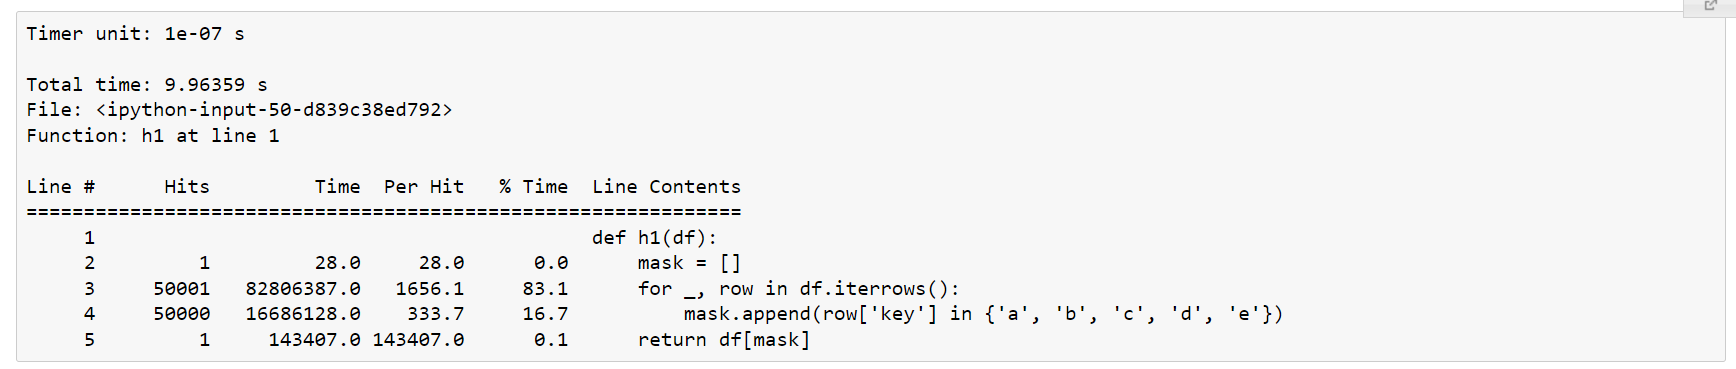

In [27]:
%%time
df[df['key'].isin({'a', 'b', 'c', 'd', 'e'})]

Wall time: 98.3 ms


,col0,col1,col2,col3,key
3,0.105590,-0.303867,-0.857950,1.700898,e
4,-0.156182,1.108920,1.005863,-0.223902,e
7,1.313007,-0.690460,-0.797278,-0.731815,e
12,-0.156375,-1.456195,-0.137882,2.380451,c
13,0.001624,1.205149,-0.439500,0.821792,e
...,...,...,...,...,...
1999978,0.079490,-0.911875,-0.629529,1.664773,e
1999980,1.498387,0.305434,0.906947,0.080666,d
1999985,-0.534869,1.237163,0.246392,-0.097751,c
1999987,0.482453,2.447727,-0.708656,0.065711,c


## Лабораторная работа 3

In [28]:
import numpy as np
import pandas as pd
from numba import jit, njit
from numba.typed import List
import numba
from typing import Union
import json
import re

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

In [29]:
recipes = pd.read_csv('recipes_sample.csv')
recipes["submitted"] = pd.to_datetime(recipes["submitted"])

reviews = pd.read_csv('reviews_sample.csv')
reviews.rename(columns={'Unnamed: 0': 'review_id'}, inplace=True)
reviews = reviews.set_index('review_id').sort_values(by='review_id')
reviews["date"] = pd.to_datetime(reviews["date"])

## Измерение времени выполнения кода

Назовем полным описанием рецепта строку, полученную путем конкатенации названия и описания рецепта через пробел. Удалите строки для рецептов, которые были добавлены не в 2010 году.

Реализуйте несколько вариантов функции подсчета средней длины полного описания рецепта для рецептов, добавленных в 2010 году.

In [30]:
recipes['desc_full'] = recipes.name + ' ' + recipes.description
recipes['desc_full']

0        george s at the cove  black bean soup an origi...
1        healthy for them  yogurt popsicles my children...
2        i can t believe it s spinach these were so go,...
3        italian  gut busters my sister-in-law made the...
4        love is in the air  beef fondue   sauces i thi...
                               ...                        
29995    zurie s holey rustic olive and cheddar bread t...
29996    zwetschgenkuchen  bavarian plum cake this is a...
29997    zwiebelkuchen   southwest german onion cake th...
29998    zydeco soup this is a delicious soup that i or...
29999    cookies by design   cookies on a stick i've he...
Name: desc_full, Length: 30000, dtype: object

In [31]:
recipes.drop(np.where(recipes.submitted.dt.year != 2010)[0], inplace=True)
recipes.head()

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients,desc_full
52,just peachy cobbler,437637,70,1085867,2010-09-17,10.0,all i can say is yummmmmm . . . a simple to ma...,10.0,just peachy cobbler all i can say is yummmmmm...
68,the heat spicy party mix,437219,95,1682162,2010-09-13,NaN,a spicy chex mix that will really warm your gu...,11.0,the heat spicy party mix a spicy chex mix tha...
81,iowa state fair sweet dough caramel cinnamon ...,435816,80,17803,2010-08-24,29.0,this was the winning entry at the 2010 iowa st...,NaN,iowa state fair sweet dough caramel cinnamon ...
104,1 minute blueberries cream,428566,2,1375473,2010-06-04,4.0,i was craving blueberry tonight but wanted non...,NaN,1 minute blueberries cream i was craving blu...
146,2 2 2 diet mocha,416599,5,789314,2010-03-15,5.0,"while trying to come up with a satisfying ""sna...",7.0,2 2 2 diet mocha while trying to come up with ...


**1\.1** С использованием метода `DataFrame.iterrows` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - нахождение полного описания рецепта осуществляется внутри цикла по `iterrows` для каждой строки по отдельности.

In [32]:
def get_mean_len_A(df: pd.DataFrame) -> float:
    desc_len = 0
    for i, row in df.iterrows():
        desc_len += len(row['name'] + ' ' + row['description'])
    return desc_len/df.shape[0]

**1\.2.** С использованием метода `DataFrame.apply` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - вызываете метод apply у таблицы, в качестве аргумента передаете функцию, которая возвращает полное описание для каждой строки;
    
    - считаете среднюю длину описаний, вызвав соответствующий метод серии.

In [33]:
def get_desc_full(df: pd.DataFrame):
    return df['name'] + ' ' + df['description']

In [34]:
def get_mean_len_B(df: pd.DataFrame) -> float:
    return df.apply(lambda x: get_desc_full(x), axis=1).str.len().mean()

**1\.3.** С использованием векторизованных методов серий `pd.Series`:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - при помощи векторизированных операций получаете столбец с полным описанием;
    
    - при помощи векторизированных операций получаете длины полного описания;
    
    - при помощи векторизированных операций получаете среднюю длину полных описаний. 

In [35]:
def get_mean_len_C(df: pd.DataFrame) -> float:
    return (df.name + ' ' + df.description).apply(len).mean()

1.4 Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций при помощи магических команд `time` и `timeit`.

In [36]:
assert get_mean_len_A(recipes) == get_mean_len_B(recipes) == get_mean_len_C(recipes)

**get_mean_len_A**

In [37]:
%time get_mean_len_A(recipes)

Wall time: 114 ms


265.501300390117

In [38]:
%timeit get_mean_len_A(recipes)

156 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**get_mean_len_B**

In [39]:
%time get_mean_len_B(recipes)

Wall time: 68.2 ms


265.501300390117

In [40]:
%timeit get_mean_len_B(recipes)

49.6 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**get_mean_len_C**

In [41]:
%time get_mean_len_C(recipes)

Wall time: 2.99 ms


265.501300390117

In [42]:
%timeit get_mean_len_C(recipes)

2.61 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Анализ пошагового выполнения кода 

Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержит то или иное слово. 

In [43]:
def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        recipe_id, review = row["recipe_id"], row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)

    word_reviews_count = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        review = row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

**2.1** Найдите узкие места в коде, проанализировав код функции по шагам, используя профайлер. Сохраните результаты работы профайлера в отдельную текстовую ячейку. Выпишите (словами), что в имеющемся коде реализовано неоптимально. 

In [44]:
# %lprun -f get_word_reviews_count get_word_reviews_count(reviews)

```
Timer unit: 1e-07 s

Total time: 180.858 s
File: <ipython-input-16-5fed0d4e2c27>
Function: get_word_reviews_count at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def get_word_reviews_count(df):
     2         1         29.0     29.0      0.0      word_reviews = {}
     3    126680  522938547.0   4128.0     28.9      for _, row in df.dropna(subset=["review"]).iterrows():
     4    126679  188459100.0   1487.7     10.4          recipe_id, review = row["recipe_id"], row["review"]
     5    126679   47758191.0    377.0      2.6          words = re.sub("[^A-Za-z\s]", "", review).split(" ")
     6   6918689   57968353.0      8.4      3.2          for word in words:
     7   6792010   77278134.0     11.4      4.3              if word not in word_reviews:
     8     93059    1473423.0     15.8      0.1                  word_reviews[word] = []
     9   6792010   86305662.0     12.7      4.8              word_reviews[word].append(recipe_id)
    10                                           
    11         1         20.0     20.0      0.0      word_reviews_count = {}
    12    126680  501380925.0   3957.9     27.7      for _, row in df.dropna(subset=["review"]).iterrows():
    13    126679  103652649.0    818.2      5.7          review = row["review"]
    14    126679   45580714.0    359.8      2.5          words = re.sub("[^A-Za-z\s]", "", review).split(" ")
    15   6918689   59074347.0      8.5      3.3          for word in words:
    16   6792010  116711331.0     17.2      6.5              word_reviews_count[word] = len(word_reviews[word])
    17         1         20.0     20.0      0.0      return word_reviews_count
```

* $56.6\text{%}$ времени функции тратится на две строки (3, 12) создания цикла (с iterrows())
* $10.4 \text{%}$ времени функции тратится на строку (4) присвоения `recipe_id` и `review`
* $6.5 \text{%}$ времени функции тратится на строку (16) заполнение словаря длинами 

**2.2**  Оптимизируйте функцию и добейтесь значительного (как минимум, в 5 раз) прироста в скорости выполнения. Для демонстрации результата измерьте скорость выполнения оригинальной функции и функции, написанной вами.

In [45]:
from collections import Counter

In [46]:
def get_word_reviews_count_opt (df):
    descs = df.dropna(subset=["review"])["review"].apply(lambda x: re.sub("[^A-Za-z\s]", "", str(x)).split(" ")).values
    words = list()

    for desc in descs:
        words.extend(desc)

    return Counter(words)

In [47]:
# %time get_word_reviews_count(reviews)

```
Wall time: 1min 8s
```

In [48]:
%time get_word_reviews_count_opt(reviews)

Wall time: 3.7 s


Counter({'very': 26040,
         'sweet': 6989,
         'after': 5843,
         'i': 7877,
         'waited': 149,
         'the': 266530,
         '': 330966,
         'days': 1168,
         'bought': 1514,
         'more': 18338,
         'pints': 107,
         'of': 109239,
         'raspberries': 355,
         'and': 219215,
         'added': 22099,
         'them': 25768,
         'to': 132170,
         'mix': 5303,
         'im': 284,
         'going': 3949,
         'add': 13152,
         'some': 21057,
         'as': 35863,
         'a': 166467,
         'cake': 6951,
         'filling': 3064,
         'today': 1915,
         'will': 24097,
         'take': 2333,
         'photo': 552,
         'Just': 2362,
         'an': 10577,
         'observation': 8,
         'so': 46848,
         'I': 288243,
         'not': 23840,
         'rate': 687,
         'followed': 4880,
         'this': 93873,
         'procedure': 18,
         'with': 59275,
         'strawberries': 823,
    

```
Wall time: 7.33 s
```

In [49]:
assert get_word_reviews_count(reviews)==get_word_reviews_count_opt(reviews)

In [50]:
print(f'Скорость уменьшилась в {round(64/7.33,2)} раз')

Скорость уменьшилась в 8.73 раз


## Numba

В файле `rating_predictions.json` хранятся данные о рейтингах рецептов и прогнозных значениях рейтингов для этого рецепта, полученных при помощи модели машинного обучения. 

Напишите несколько версий функции (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от прогнозного значения рейтинга для данного рецепта. 


Замечание 1: в формуле MAPE под $A_t$ понимается рейтинг из отзыва $t$, под $F_t$ - прогнозное значения рейтинга отзыва $t$.

Замечание 2: в результате работы функций должно получиться одно число - MAPE для всего набора данных.

$${\displaystyle {\mbox{MAPE}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|}$$

In [51]:
rating_pred = json.loads(open('rating_predictions.json', mode='r', encoding='utf-8').read())

In [52]:
sum(list(map(lambda t: abs((t['rating']-t['prediction'])/t['rating']), rating_pred))) * 100 / len(rating_pred)

13.325265503992638

**3\.1** Создайте два списка `A_list` и `F_list` на основе файла `rating_predictions.json`. Напишите функцию `mape_lists` без использования векторизованных операций и методов массивов `numpy` и без использования `numba` (проитерируйтесь по спискам и вычислите суммарное значение MAPE для всех элементов, а потом усредните результат).

Измерьте время выполнения данной функции на входных данных `A_list` и `F_list`. Временем, затрачиваемым на создание списков, можно пренебречь.
    

In [53]:
def mape_lists(A=list, F=list):
    error_sum = 0
    n = len(A)
    for item in range(n):
        error_sum += abs((A[item] - F[item])/A[item])
    return error_sum * 100 / n

In [54]:
A_list = list(map(lambda t: t['rating'], rating_pred))
F_list = list(map(lambda t: t['prediction'], rating_pred))

%time mape_lists(A_list, F_list)

Wall time: 23.9 ms


13.325265503992638

In [55]:
%timeit mape_lists(A_list, F_list)

25.8 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**3\.2.** Создайте массивы `numpy` `A_array` и `F_array` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numpy` с использованием векторизованных операций и методов массивов `numpy`.

Измерьте время выполнения данной функции на входных данных `A_array` и `F_array`. Временем, затрачиваемым на создание массивов, можно пренебречь.

In [56]:
def mape_numpy(A=list, F=list):
    return np.sum(np.absolute((A - F) / A)) * 100 / len(A)

In [57]:
A_array = np.array(A_list)
F_array = np.array(F_list)

%time mape_numpy(A_array, F_array)

Wall time: 2.99 ms


13.32526550399145

In [58]:
%timeit mape_numpy(A_array, F_array)

270 µs ± 34.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**3\.3.** Создайте объекты `numba.typed.List` `A_typed` и `F_typed` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numba` без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`. 

Измерьте время выполнения данной функции на входных данных `A_typed` и `F_typed`. Временем, затрачиваемым на создание объектов `numba.typed.List`, можно пренебречь.

Измерьте время выполнения данной функции на входных данных `A_numpy` и `F_numpy`.

In [59]:
@njit
def mape_numba(A=list, F=list):
    error_sum = 0
    n = len(A)
    for item in range(n):
        pass
        error_sum += abs((A[item] - F[item])/A[item])
    return error_sum * 100 / n

In [60]:
A_typed = List(A_list)
F_typed = List(F_list)

1 запуск

In [61]:
%time mape_numba(A_typed, F_typed)

Wall time: 376 ms


13.325265503992638

2 запуск

In [62]:
%time mape_numba(A_typed, F_typed)

Wall time: 1.99 ms


13.325265503992638

1 запуск

In [63]:
%time mape_numba(A_array, F_array)

Wall time: 192 ms


13.325265503992638

2 запуск

In [64]:
%time mape_numba(A_array, F_array)

Wall time: 0 ns


13.325265503992638

## Векторизация

Сайт-агрегатор устроил акцию: он дарит купоны на посещение ресторана тем пользователям, оставившим отзывы, идентификатор которых является _красивым числом_. Натуральное число называется _красивым_ , если первая цифра числа совпадает с последней цифрой числа. 



In [65]:
reviews.user_id

review_id
5               52282
6              124416
7          2000192946
8               76535
9              273745
              ...    
1132291        681416
1132292       1986433
1132293       2317533
1132326       1963163
1132352       1269180
Name: user_id, Length: 126696, dtype: int64

**4\.1** Напишите функцию `is_pretty`, которая для каждого идентификатора пользователя из файла определяет, получит ли он подарок. Запрещается преобразовывать идентификатор пользователя к строке. Подтвердите корректность реализации, продемонстрировав примеры.

In [66]:
def is_pretty(n: int) -> bool:
    last = n%10
    while n > 9:
        n = n//10
    return n == last

In [67]:
is_pretty(12345), is_pretty(123451)

(False, True)

**4\.2** Посчитайте с помощью функции `is_pretty` количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.

In [68]:
len(set(reviews.user_id)) == len(reviews.user_id.index) # проверим, что есть хотя бы один uder_id, который повторяется

False

In [70]:
len(pd.unique(reviews.user_id))

44803

In [71]:
# ids = reviews["recipe_id"].values 
ids = reviews["user_id"].values # Я изменил "recipe_id" на "user_id", чтобы резульат соответстовал условиям задачи

reviews.iloc[np.where(reviews.user_id.apply(lambda id: is_pretty(id)).values == True)[0]]

,user_id,recipe_id,date,rating,review
review_id,,,,,
242,200862,336795,2011-11-05,5,"Trinkets, I apologise for having had to use zu..."
247,461834,373842,2013-09-22,5,Wonderful quiche!! I made 1/3 of the recipe a...
320,75497,77021,2008-01-08,3,"I loved this, but my daughter and husband woul..."
447,143721,426090,2012-08-17,5,Great new way to do green beans. I really lik...
508,1091591,77001,2008-12-22,5,I made this recipe for the first time tonight ...
...,...,...,...,...,...
1132177,55655,79642,2003-12-28,5,Great way to do parsnips!!! This recipe provid...
1132226,262312,205412,2008-11-10,5,nice variation to an old favorite. my mom use...
1132250,706377,124136,2008-06-23,5,I've been making a version of this that I've f...


In [77]:
%time len(set(reviews.iloc[np.where(reviews.user_id.apply(lambda id: is_pretty(id)).values == True)[0]].user_id.values))

Wall time: 179 ms


4389

**4\.3.** При помощи `numpy` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [81]:
is_pretty_numpy = np.vectorize(is_pretty)
unq_ids = list(set(ids))

%time len(np.where(is_pretty_numpy(unq_ids) == True)[0])

Wall time: 172 ms


4389

**4\.4.** При помощи `numba` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [79]:
is_pretty_numba = numba.vectorize(["int64(int64)"])(is_pretty)
%time len(np.where(is_pretty_numba(unq_ids) == True)[0])

Wall time: 4.43 ms


4389